In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
delhi_data = pd.read_csv('./Data/Delhi_AQI_Dataset.csv')
delhi_data.drop(delhi_data[['Unnamed: 9','Unnamed: 10']],axis=1, inplace=True)

In [3]:
# Taking only AQI data for daily, weekly and bi-weekly values

aqi_daily = delhi_data[['Date', 'AQI']]
aqi_daily['Date'] = pd.to_datetime(aqi_daily['Date'])
aqi_daily.set_index('Date', inplace=True)   

aqi_biweekly = aqi_daily.resample('2W').mean()   
aqi_biweekly = aqi_biweekly.iloc[:-1]

aqi_weekly = aqi_daily.resample('W').mean()   
aqi_weekly = aqi_weekly.iloc[:-1]

/var/folders/04/9hpgxw412jn1mgrbgs6nxncm0000gn/T/ipykernel_46547/1294224638.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  aqi_daily['Date'] = pd.to_datetime(aqi_daily['Date'])
/var/folders/04/9hpgxw412jn1mgrbgs6nxncm0000gn/T/ipykernel_46547/1294224638.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqi_daily['Date'] = pd.to_datetime(aqi_daily['Date'])


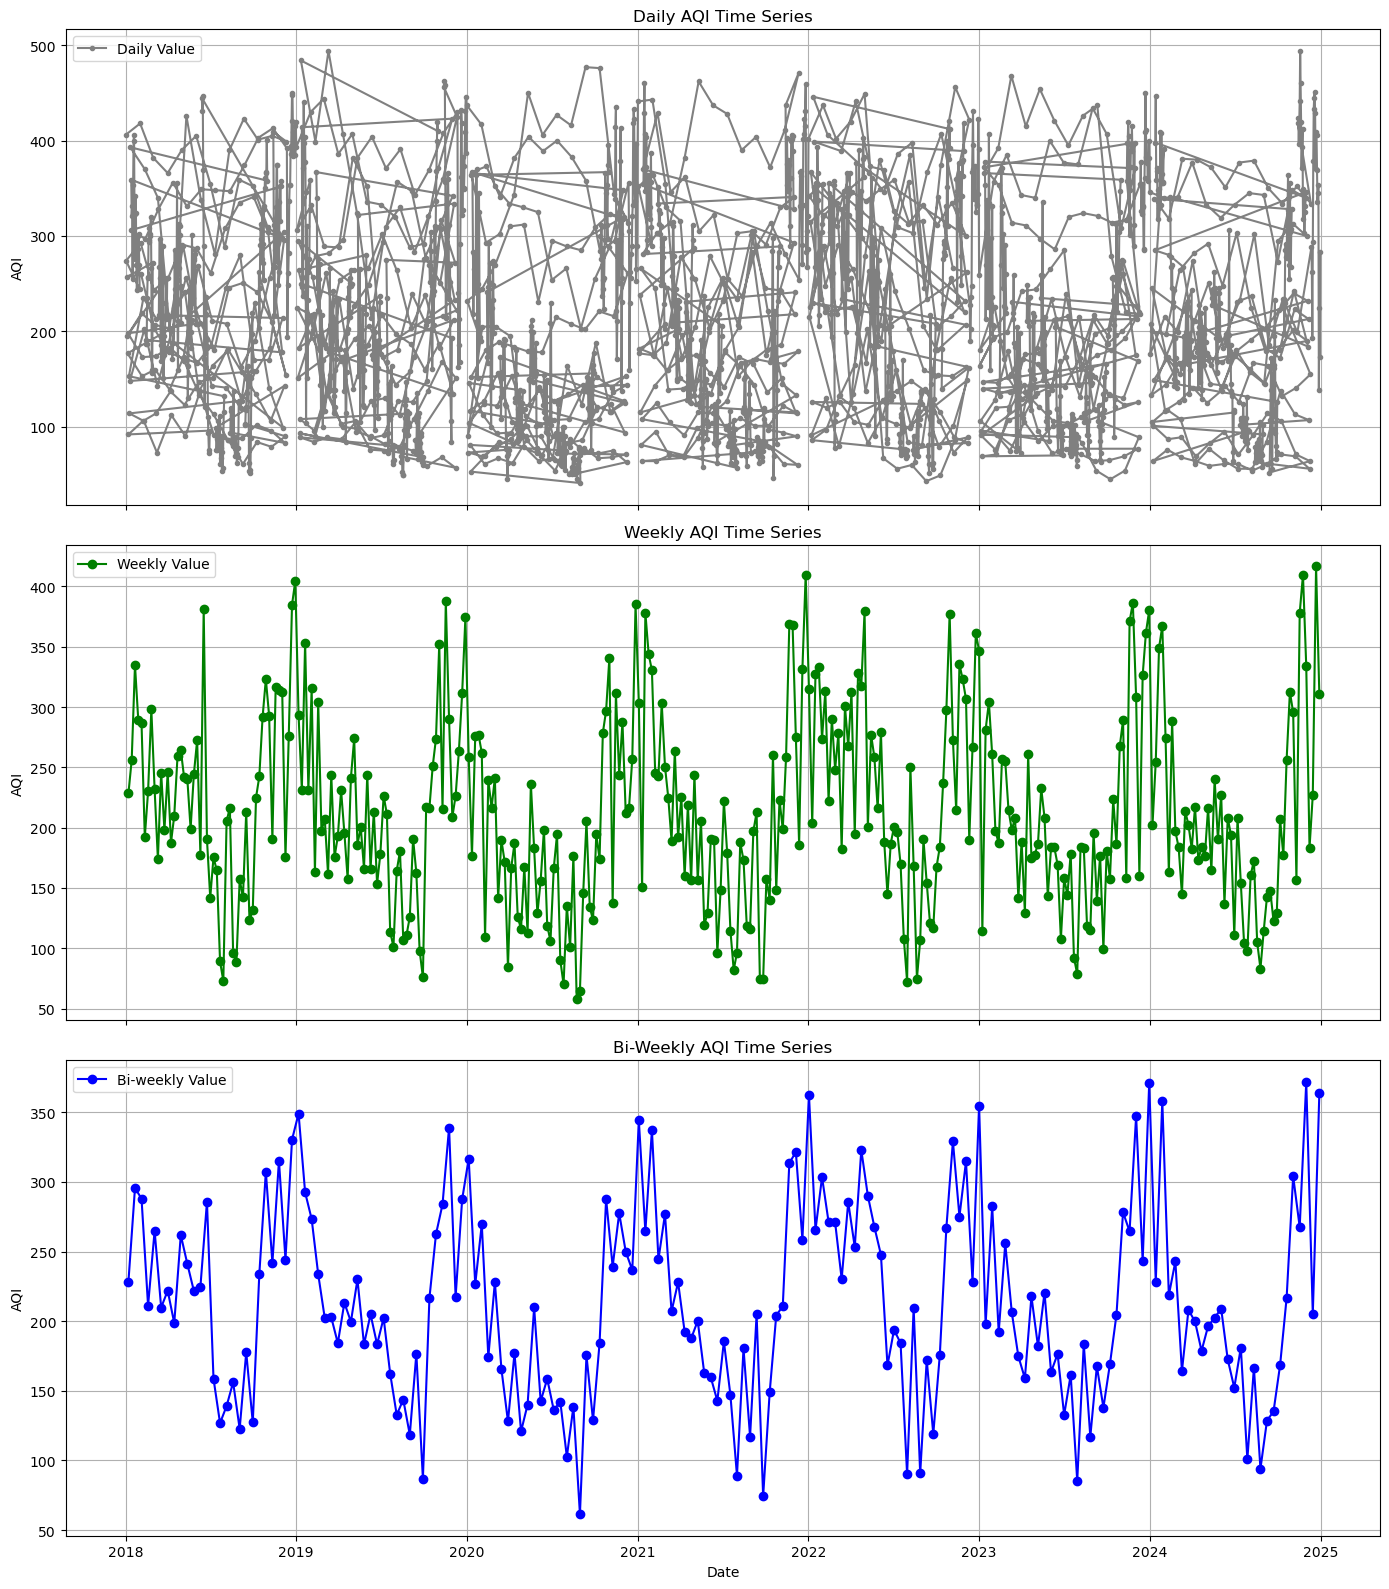

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 16), sharex=True)

# Daily Plot
axes[0].plot(aqi_daily.index, aqi_daily['AQI'], marker='.', linestyle='-', color='gray', label='Daily Value')
axes[0].set_title('Daily AQI Time Series')
axes[0].set_ylabel('AQI')
axes[0].legend()
axes[0].grid(True)

# Weekly Plot
axes[1].plot(aqi_weekly.index, aqi_weekly['AQI'], marker='o', linestyle='-', color='g', label='Weekly Value')
axes[1].set_title('Weekly AQI Time Series')
axes[1].set_ylabel('AQI')
axes[1].legend()
axes[1].grid(True)

# Biweekly Plot
axes[2].plot(aqi_biweekly.index, aqi_biweekly['AQI'], marker='o', linestyle='-', color='b', label='Bi-weekly Value')
axes[2].set_title('Bi-Weekly AQI Time Series')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('AQI')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

Taken weekly and biweekly averages of the data as daily values are too erratic. For final modeling, I ended up taking biweekly data as weekly was still a little too erratic and difficult to model

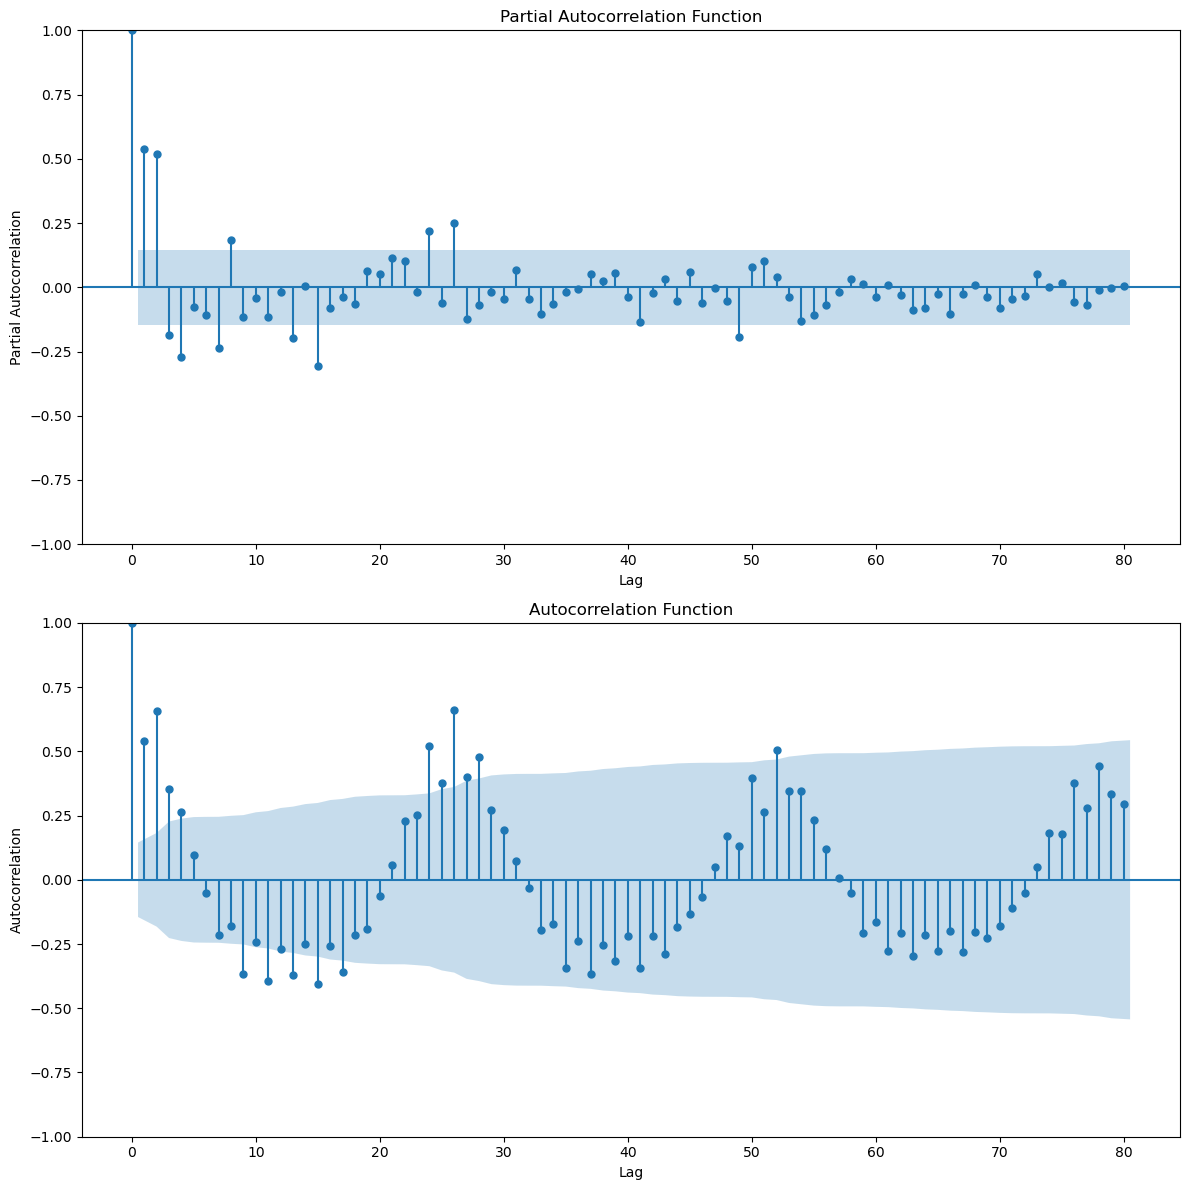

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot PACF
plot_pacf(aqi_biweekly, lags=80, ax=axes[0])
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Partial Autocorrelation')
axes[0].set_title('Partial Autocorrelation Function')

# Plot ACF
plot_acf(aqi_biweekly, lags=80, ax=axes[1])
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')
axes[1].set_title('Autocorrelation Function')

plt.tight_layout()
plt.savefig("acf.png")
plt.show()

The plots suggest an Auto-Regressive model of order 4 with seasonal patterns

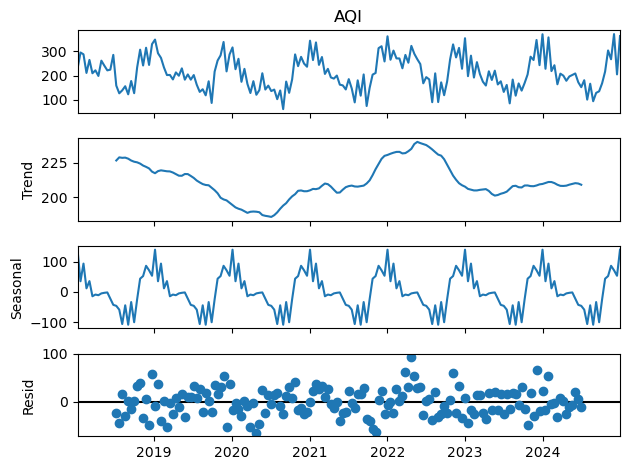

In [6]:
# Perform seasonal decomposition
result = seasonal_decompose(aqi_biweekly['AQI'], model='additive', period=26)  # Adjust period based on seasonality

# Plot the decomposition
result.plot()
plt.savefig("seasonal_decomp.png")
plt.show()

We see a downward trend in the AQI after 2018 and sudden downfall during Covid lockdowns followed by the overall upward trend. The plot also suggests a seasonal or cyclic trend in the data which is because of the same patterns every year due to season changes and fixed events

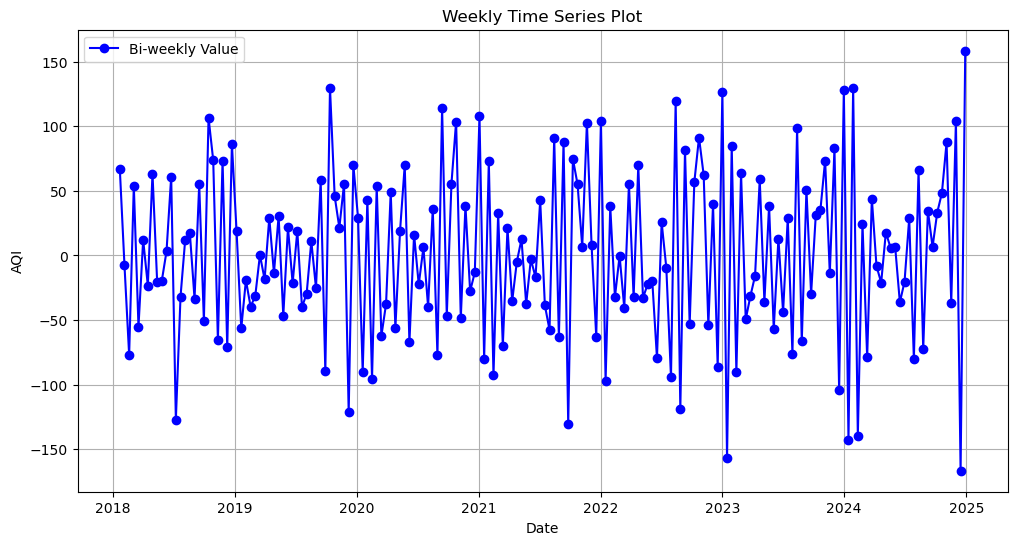

In [7]:
# Checking which difference removes the trend

first_diff = aqi_biweekly.diff()[1:]
plt.figure(figsize=(12, 6))
plt.plot(first_diff.index, first_diff['AQI'], marker='o', linestyle='-', color='b', label='Bi-weekly Value')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Weekly Time Series Plot')
plt.legend()
plt.grid(True)
plt.show()

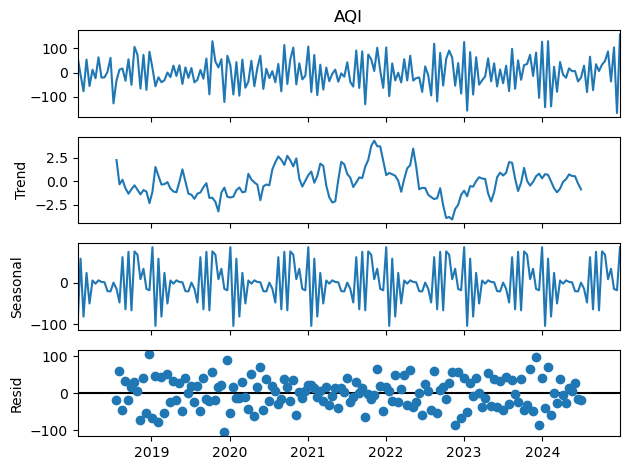

In [8]:
# Perform seasonal decomposition
result = seasonal_decompose(first_diff['AQI'], model='additive', period=26)  # Adjust period based on seasonality

# Plot the decomposition
result.plot()
plt.savefig("seasonal_decomp.png")
plt.show()

First difference was enough to make the data stationary

## SARIMA Modeling

In [9]:
# Train-test split

train_end = datetime(2023,12,31)
test_end = datetime(2024,12,31)

train_sarima = aqi_biweekly[:train_end]
test_sarima = aqi_biweekly[train_end + timedelta(days=1):test_end]

In [10]:
# Fit SARIMAX model
sarima = SARIMAX(train_sarima, order=(4, 1, 2), seasonal_order=(1, 0, 0, 26))
model_fit_sarima = sarima.fit()

# Print model summary
print(model_fit_sarima.summary())

/Users/pranitahuja/anaconda3/envs/CMSE890/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pranitahuja/anaconda3/envs/CMSE890/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                                 AQI   No. Observations:                  157
Model:             SARIMAX(4, 1, 2)x(1, 0, [], 26)   Log Likelihood                -796.684
Date:                             Sun, 20 Apr 2025   AIC                           1609.369
Time:                                     22:43:24   BIC                           1633.768
Sample:                                 01-07-2018   HQIC                          1619.279
                                      - 12-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1803      0.610      0.296      0.767      -1.015       1.375
ar.L2          0.5090      

/Users/pranitahuja/anaconda3/envs/CMSE890/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA((4,1,2),(1,0,0,26)) seems to be the best fit according to the lower AIC and higer neg-log-likelihood

/var/folders/04/9hpgxw412jn1mgrbgs6nxncm0000gn/T/ipykernel_46547/1693766601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sarima['y_pred_sarima'] = y_pred_sarima


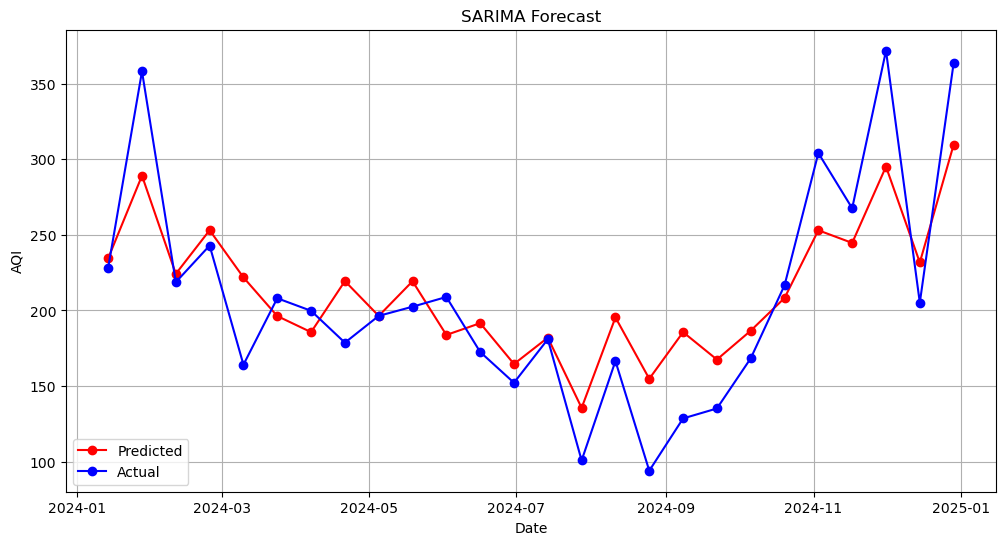

R Squared: 0.7437278443352477
Root Mean Squared Error: 36.550414155070804
Mean Absolute Error: 29.26968018165798


In [26]:
y_pred_sarima = model_fit_sarima.predict(start=len(train_sarima), end=len(train_sarima)+len(test_sarima)-1)
test_sarima['y_pred_sarima'] = y_pred_sarima

plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, test_sarima['y_pred_sarima'], linestyle='-', marker='o', color='r', label='Predicted')
plt.plot(test_sarima.index, test_sarima['AQI'], linestyle='-', marker='o', color='b', label='Actual')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('SARIMA Forecast')
plt.legend()
plt.grid(True)
plt.savefig("my_plot.png")
plt.show()

r2 = r2_score(test_sarima['AQI'], test_sarima['y_pred_sarima'])
print("R Squared:", r2)

rmse = root_mean_squared_error(test_sarima['AQI'], test_sarima['y_pred_sarima'])
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(test_sarima['AQI'], test_sarima['y_pred_sarima'])
print("Mean Absolute Error:", mae)

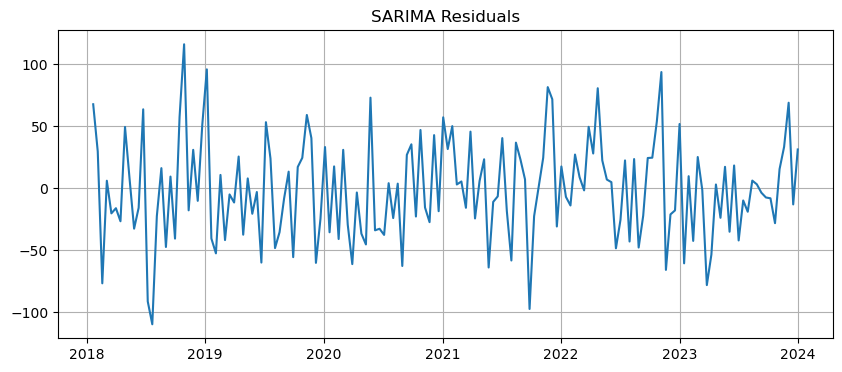

In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residuals
residuals = model_fit_sarima.resid

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals[1:])
plt.title("SARIMA Residuals")
plt.grid(True)
plt.show()

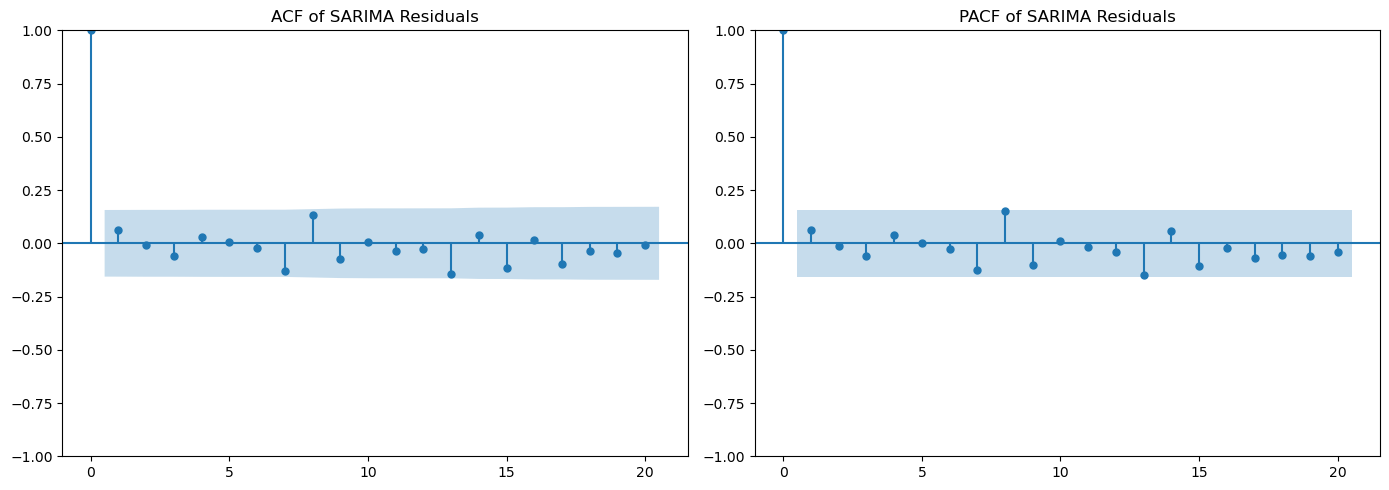

Ljung-Box Test:
     lb_stat  lb_pvalue
10  8.306725   0.598904


In [13]:
# Plot ACF and PACF of residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(residuals, ax=axes[0], lags=20)
axes[0].set_title('ACF of SARIMA Residuals')

plot_pacf(residuals, ax=axes[1], lags=20)
axes[1].set_title('PACF of SARIMA Residuals')

plt.tight_layout()
plt.show()

# Ljung-Box test
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test:")
print(ljung_box_result)

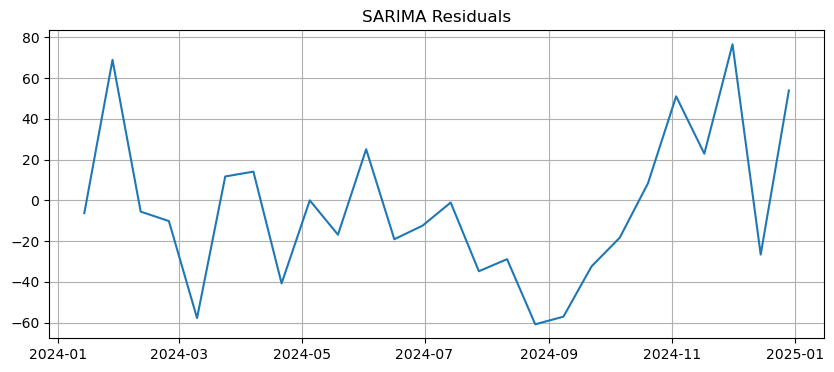

In [14]:
# Residuals and Ljung-Box test for just the test data
# Residuals = actual - predicted
sarima_residuals = test_sarima['AQI'] - test_sarima['y_pred_sarima']

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(sarima_residuals)
plt.title("SARIMA Residuals")
plt.grid(True)
plt.show()

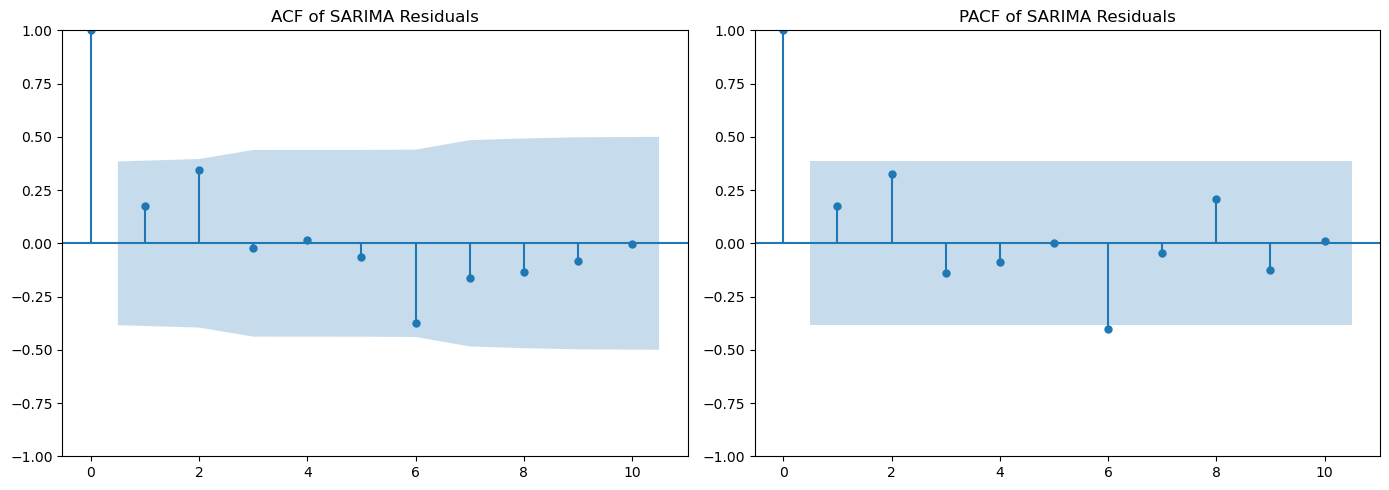

Ljung-Box Test:
      lb_stat  lb_pvalue
10  11.788942    0.29943


In [15]:
# Plot ACF and PACF of residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(sarima_residuals, ax=axes[0], lags=10)
axes[0].set_title('ACF of SARIMA Residuals')

plot_pacf(sarima_residuals, ax=axes[1], lags=10)
axes[1].set_title('PACF of SARIMA Residuals')

plt.tight_layout()
plt.show()

# Ljung-Box test
ljung_box_result = acorr_ljungbox(sarima_residuals, lags=[10], return_df=True)
print("Ljung-Box Test:")
print(ljung_box_result)

The Ljung-Box test gave a high p-value meaning we fail to reject the null hypothesis of no correlation between the residuals which means the SARIMA model is a good fit and was able to capture the dependencies in the series very well. The same can be seen in the ACF and PACF plots thta there is no significant autocorrelation

## LSTM

In [16]:
# Step 1: Scale AQI data and preserve datetime index
aqi_df = aqi_biweekly.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
aqi_df['AQI_scaled'] = scaler.fit_transform(aqi_df[['AQI']])

# Step 2: Create sequences with corresponding dates
def create_sequences_with_dates(series, n_steps):
    X, y, dates = [], [], []
    for i in range(len(series) - n_steps):
        X.append(series.iloc[i:i + n_steps].values)
        y.append(series.iloc[i + n_steps])
        dates.append(series.index[i + n_steps])
    return np.array(X), np.array(y), pd.to_datetime(dates)

# Set sequence length
n_steps = 6

# Create LSTM-ready sequences
X, y, y_dates = create_sequences_with_dates(aqi_df['AQI_scaled'], n_steps)

# Step 3: Split into training and testing sets (last 26 for testing)
test_size = 26
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]
y_dates_train, y_dates_test = y_dates[:-test_size], y_dates[-test_size:]

# Step 4: Reshape inputs for LSTM: (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Shapes:
X_train: (151, 6, 1)
y_train: (151,)
X_test: (26, 6, 1)
y_test: (26,)


In [17]:
# build lstm model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_steps, 1)))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))  # Last layer (doesn't return sequences)
model.add(Dropout(0.3))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


2025-04-20 22:43:25.806756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-20 22:43:25.807648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-20 22:43:25.808093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/5 [=====>........................] - ETA: 5s - loss: 0.2987

2025-04-20 22:43:27.615269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-20 22:43:27.615919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-20 22:43:27.616451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 2s 100ms/step - loss: 0.2497 - val_loss: 0.1696
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.1211 - val_loss: 0.0623
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0592 - val_loss: 0.0810
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0731 - val_loss: 0.0541
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0542 - val_loss: 0.0588
Epoch 6/50
5/5 [==============================] - 0s 10ms/step - loss: 0.0521 - val_loss: 0.0551
Epoch 7/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0510 - val_loss: 0.0533
Epoch 8/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0522 - val_loss: 0.0535
Epoch 9/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0506 - val_loss: 0.0525
Epoch 10/50
5/5 [==============================] - 0s 9ms/step - loss: 0.0484 - val_loss: 0.0525
Epoch 11/50
5/5 [=============================

2025-04-20 22:43:29.852495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-20 22:43:29.853006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-20 22:43:29.853602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 325ms/step
LSTM R Squared: 0.36, RMSE: 57.78, MAE: 43.89


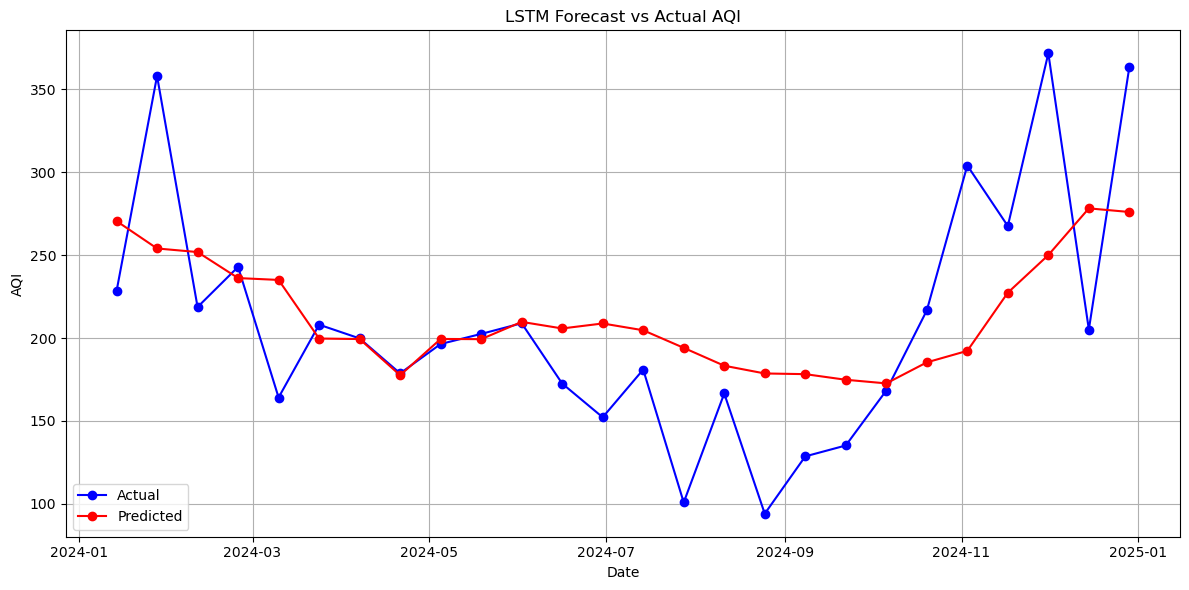

In [18]:
# predict
y_pred_lstm = model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))

# Reshape y_test to (n_samples, 1) before inverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
r2 = r2_score(y_test_inv, y_pred_lstm)
rmse = root_mean_squared_error(y_test_inv, y_pred_lstm)
mae = mean_absolute_error(y_test_inv, y_pred_lstm)
print(f"LSTM R Squared: {r2:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_dates_test, y_test_inv, linestyle='-', marker='o', color='b', label='Actual')
plt.plot(y_dates_test, y_pred_lstm, linestyle='-', marker='o', color='r', label='Predicted')
plt.title('LSTM Forecast vs Actual AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Till now SARIMA is working better at recognising the spikes in the data as well as the overall trend due to focusing on the trend and seasonality part whereas the LSTM is only focussed on the AQI values

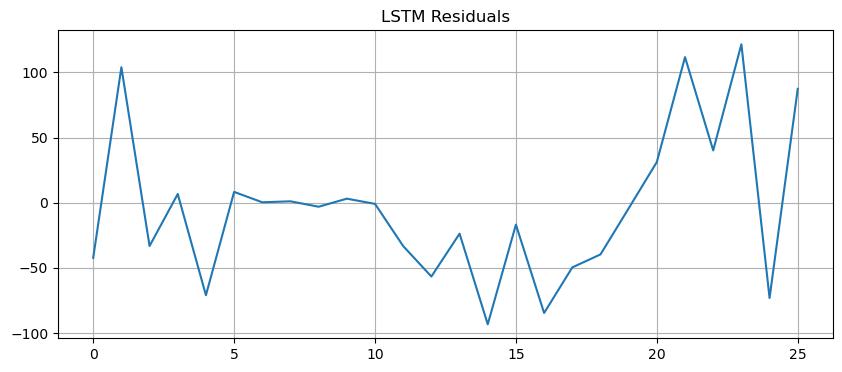

In [19]:
# Residuals = actual - predicted
lstm_residuals = y_test_inv.flatten() - y_pred_lstm.flatten()

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(lstm_residuals)
plt.title("LSTM Residuals")
plt.grid(True)
plt.show()

In [20]:
ljung_box_lstm = acorr_ljungbox(lstm_residuals, lags=[10], return_df=True)
print("Ljung-Box Test for LSTM:")
print(ljung_box_lstm)

Ljung-Box Test for LSTM:
      lb_stat  lb_pvalue
10  15.320852   0.120795


## Second LSTM Approach: Adding Stationarity information to check if LSTM improves

In [21]:
aqi_df_events = aqi_biweekly.copy()
scaler = MinMaxScaler()
aqi_df_events['AQI'] = scaler.fit_transform(aqi_df_events[['AQI']])

# Adding one-hot encoding for festivals and events that affected Delghi AQI during this time

# 1. Diwali season: Oct 15 to Nov 15
aqi_df_events['diwali'] = aqi_df_events.index.map(lambda x: 1 if (x.month == 10 and x.day >= 15) or (x.month == 11 and x.day <= 15) else 0)

# 2. Crop burning season: Oct 15 to Nov 30
aqi_df_events['crop_burning'] = aqi_df_events.index.map(lambda x: 1 if (x.month == 10 and x.day >= 15) or (x.month == 11) else 0)

# 3. Winter season: Dec to Feb
aqi_df_events['winter'] = aqi_df_events.index.map(lambda x: 1 if x.month in [12, 1, 2] else 0)

# 4. Monsoon season: July to September
aqi_df_events['monsoon'] = aqi_df_events.index.map(lambda x: 1 if x.month in [7, 8, 9] else 0)

# 5. Summer season: April to June
aqi_df_events['summer'] = aqi_df_events.index.map(lambda x: 1 if x.month in [4, 5, 6] else 0)

# 6. New Year celebrations: early January
aqi_df_events['new_year'] = aqi_df_events.index.map(lambda x: 1 if x.month == 1 and x.day <= 7 else 0)

# 7. Independence Day: Aug 8–21
aqi_df_events['independence_day'] = aqi_df_events.index.map(lambda x: 1 if x.month == 8 and 8 <= x.day <= 21 else 0)

aqi_df_events

,AQI,diwali,crop_burning,winter,monsoon,summer,new_year,independence_day
Date,,,,,,,,
2018-01-07,0.538107,0,0,1,0,0,1,0
2018-01-21,0.754548,0,0,1,0,0,0,0
2018-02-04,0.730140,0,0,1,0,0,0,0
2018-02-18,0.482155,0,0,1,0,0,0,0
2018-03-04,0.655768,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2024-11-03,0.781948,1,1,0,0,0,0,0
2024-11-17,0.664287,0,1,0,0,0,0,0
2024-12-01,1.000000,0,0,1,0,0,0,0


Here, I have added the events that reepat around the same time every year, like a cyclic or seasonal pattern which can help LSTM get an idea of the seasonal spikes and understand them better. These events have been added as one-hot encoded variables against there respective time points.

In [22]:
def create_multivariate_sequences(data, n_steps=6):
    X, y, y_dates = [], [], []
    for i in range(len(data) - n_steps):
        X.append(data.iloc[i:i+n_steps].values)         # All features for each step
        y.append(data.iloc[i+n_steps]['AQI'])           # Predicting AQI only
        y_dates.append(data.index[i+n_steps])
    return np.array(X), np.array(y), pd.to_datetime(y_dates)

X, y, y_dates = create_multivariate_sequences(aqi_df_events, n_steps=6)

test_size = 26
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]
y_dates_train, y_dates_test = y_dates[:-test_size], y_dates[-test_size:]

print("X_train shape:", X_train.shape)  # (samples, 6, 8)
print("y_train shape:", y_train.shape)  # (samples,)

X_train shape: (151, 6, 8)
y_train shape: (151,)


In [23]:
# build lstm model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(6, 8)))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))  # Last layer (doesn't return sequences)
model.add(Dropout(0.3))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


2025-04-20 22:43:30.341940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-20 22:43:30.342430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-20 22:43:30.342862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/5 [=====>........................] - ETA: 5s - loss: 0.2638

2025-04-20 22:43:32.072448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-20 22:43:32.073290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-20 22:43:32.073878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 2s 91ms/step - loss: 0.2210 - val_loss: 0.1335
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0887 - val_loss: 0.0590
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.0681 - val_loss: 0.0512
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0483 - val_loss: 0.0431
Epoch 5/50
5/5 [==============================] - 0s 26ms/step - loss: 0.0485 - val_loss: 0.0398
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0444 - val_loss: 0.0287
Epoch 7/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0328 - val_loss: 0.0293
Epoch 8/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0401 - val_loss: 0.0271
Epoch 9/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.0285
Epoch 10/50
5/5 [==============================] - 0s 8ms/step - loss: 0.0380 - val_loss: 0.0267
Epoch 11/50
5/5 [==============================]

2025-04-20 22:43:34.310381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-20 22:43:34.311067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-20 22:43:34.311467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 313ms/step
LSTM R Squared: 0.64, RMSE: 43.17, MAE: 31.80


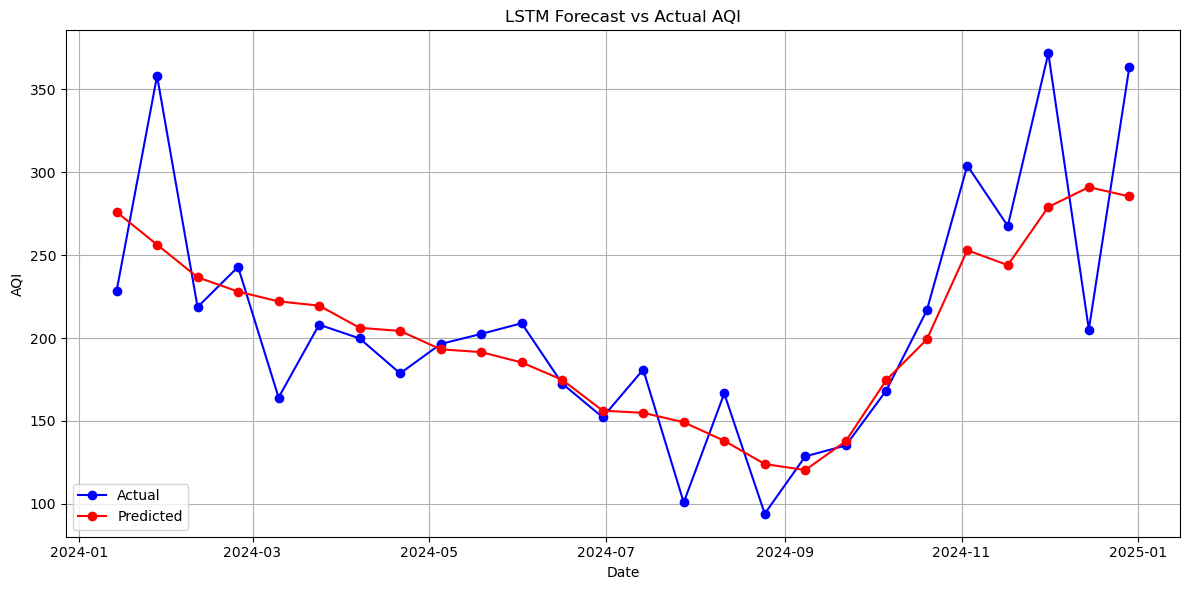

In [24]:
# predict
y_pred_lstm_events = model.predict(X_test)
y_pred_lstm_events = scaler.inverse_transform(y_pred_lstm_events.reshape(-1, 1))

# Reshape y_test to (n_samples, 1) before inverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
r2 = r2_score(y_test_inv, y_pred_lstm_events)
rmse = root_mean_squared_error(y_test_inv, y_pred_lstm_events)
mae = mean_absolute_error(y_test_inv, y_pred_lstm_events)
print(f"LSTM R Squared: {r2:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_dates_test, y_test_inv, linestyle='-', marker='o', color='b', label='Actual')
plt.plot(y_dates_test, y_pred_lstm_events , linestyle='-', marker='o', color='r', label='Predicted')
plt.title('LSTM Forecast vs Actual AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This is doing much better than the LSTM working with just AQI values as it can better understand the overall trend and the rise and downfalls due to repeating patterns. However, SARIMA is still better at forecasting the sudden spikes or changes in the data while LSTM gives sort of a smoother forecast as it focuses on minimizing the average loss.

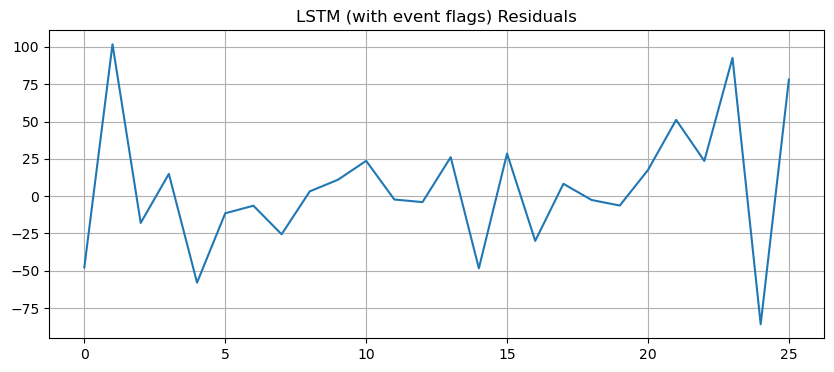

In [25]:
# Residuals = actual - predicted
lstm_events_residuals = y_test_inv.flatten() - y_pred_lstm_events.flatten()

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(lstm_events_residuals)
plt.title("LSTM (with event flags) Residuals")
plt.grid(True)
plt.show()